# Black-Body Radiation

*Colin Leach, May 2018*

## Contents

- [Planck curves](#Planck)
- [Wien's Displacement Law](#Wien)
- [Energy Flux Density](#Flux)
- [What do these colors look like?](#Colors)

<a id='Planck'></a>
## Planck curves

These give energy distribution by freq or wavelength:
$$ B_{\lambda} = \frac{2hc^2}{\lambda^5} \cdot \frac{1}{e^{hc / \lambda kT} - 1} \qquad \text{or} \qquad B_{\nu} = \frac{2h \nu^2}{c^2} \cdot \frac{1}{e^{hc / \lambda kT} - 1} $$

In [1]:
%matplotlib inline 

import numpy as np
import matplotlib.pyplot as plt

# from IPython.display import Image, HTML
# from matplotlib import animation
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as w

from astropy import units as u
from astropy.constants import h, c, k_B, b_wien, sigma_sb

In [1]:
def B_lambda(lambd, T):
    lambd = lambd.to(u.m)
    return 2*h*c**2/(lambd**5*(np.exp(h*c/(lambd*k_B*T.to(u.K))) - 1))

The `B_lambda` function works in SI units and returns values in $J \cdot s^{-1} \cdot m^{-3}$. The plot below uses $kW \cdot sr^{-1} \cdot m^{-2} \cdot nm^{-1}$, emphasising that $B_{\lambda}$ is power per unit area per unit wavelength.

In [4]:
def plotBB(lambdaRange, temps):
    fig = plt.figure(figsize=(12,8))
    lambd = np.linspace(lambdaRange[0], lambdaRange[1], 100)*u.nm
    temps = [int(t) for t in temps.split(',')]*u.K
    for T in temps:
        # calculate B and massage the units
        B_list = (B_lambda(lambd, T).to(u.kW/(u.m**2*u.nm)))/u.sr
        plt.plot(lambd, B_list, label='T={0:4.0f}'.format(T))
    plt.xlabel('wavelength $\lambda$ (nm)')
    plt.ylabel('B ($kW \cdot sr^{-1} \cdot m^{-2} \cdot nm^{-1}$)')
    plt.ylim(bottom=0)
    plt.legend()
    plt.title('Blackbody Radiation')

style = {'description_width': 'initial'}
interact(plotBB, 
             lambdaRange = w.IntRangeSlider(description="Wavelength range (nm)", style=style,
                                            layout=Layout(width='80%'),
                                            continuous_update=False, # otherwise flicker is horrible
                                            min=10, max=10000, step=10, 
                                            value=[100, 2000]), 
             temps = w.Text(description="Temps (K), comma-separated values", style=style,
                            continuous_update=False,
                            layout=Layout(width='80%'),
                            value="3000,4000,5000"));


interactive(children=(IntRangeSlider(value=(100, 2000), continuous_update=False, description='Wavelength range…

<a id='Wien'></a>
## Wien's displacement law

This is a very simple relationship between peak wavelength and temperature:
$$ \lambda_{max} = \frac{b_{wien}}{T} \qquad \text{where} \qquad b_{wien} = 2.9 \cdot 10^{-3}\ [m.K] = 2.9 \cdot 10^7\ [A.K]$$

In [5]:
lambda_max = lambda T: (b_wien/(T*u.K)).to(u.nm)
interact(lambda_max, T=w.IntSlider(description="T (K)",
                                            min=10, max=100000, step=10, 
                                            value=3000));

interactive(children=(IntSlider(value=3000, description='T (K)', max=100000, min=10, step=10), Output()), _dom…

<a id='Flux'></a>
## Energy flux density

This is luminance across the entire spectrum ($M$ is power/unit area, $\sigma$ is the Stefan-Boltzmann constant):
$$M = \sigma T^4  \qquad \text{where} \qquad \sigma = 5.67 \cdot 10^{-5}\ [erg.s^{-1}.cm^{-2}.K^{-4}] = 5.67 \cdot 10^{-8}\ [W.m^{-2}.K^{-4}]$$


In [6]:
M_sb = lambda T: sigma_sb*(T*u.K)**4
interact(M_sb, T=w.IntSlider(description="T (K)",
                             continuous_update=False, # to avoid confusing MathJax
                             min=10, max=100000, step=10, 
                             value=3000));

interactive(children=(IntSlider(value=3000, continuous_update=False, description='T (K)', max=100000, min=10, …

---------------
<a id='Colors'></a>

## What do these colors look like?

Give the vagaries of human vision and computer monitors, the next section will be approximate and subjective (at best).

How do we get a Python RGB value from a temperature? Hitting Google will give several published lists that can be used as lookup tables, plus an algorithm to calculate it on the fly.

The short answer is that a "black" body will look white at a temperature around 6500-6600 K. Above that it looks increasingly blue. Below that it gos through a yellow-orange-red spectrum. Obviously this is not new information: people (expecially blacksmiths) had been looking closely at color changes in heated iron bars for many centuries before Planck.

This function uses one of the possible lookup tables, stored in a csv file:

In [7]:
# Read in the file once and store it in a top-level dictionary for repeated use
import csv
reader = csv.reader(open('../files/rgb_temp.csv', 'r'))
tempdict = {}
for row in reader:
   k, v = row
   tempdict[k] = v

def lookup_temp(T):
    """
        Input is a temperature in K
        Must be a value, e.g. float, not an astropy Quantity
        
        For the data and discussion, see:
        http://www.vendian.org/mncharity/dir3/blackbody/
    """
    
    # lookup table only has data for 1k <= T <= 40k
    if T < 1000:
        T = 1000
    elif T > 40000:
        T = 40000
    tempkey = str(int(T/100)*100)
    return tempdict[tempkey];

This function implements Tanner Helland's algorithm:

In [8]:
def th_color(T):
    """
        Input is a temperature in K
        Must be a value, e.g. float, not an astropy Quantity
        
        For the algorithm and caveats, see:
        http://www.tannerhelland.com/4435/convert-temperature-rgb-algorithm-code/
    """
    
    T = T/100
    
    # red
    if T <= 66:
        red = 255
    else:
        red = T - 60
        red = 329.698727446 * (red**(-0.1332047592))
        if red < 0: red = 0
        if red > 255: red = 255
    
    # green
    if T <= 66:
        green = T
        green = 99.4708025861 * np.log(green) - 161.1195681661
        if green < 0: green = 0
        if green > 255: green = 255
    else:
        green = T - 60
        green = 288.1221695283 * (green**(-0.0755148492))
        if green < 0: green = 0
        if green > 255: green = 255
    
    # blue
    if T >= 66:
        blue = 255
    else:
        blue = T - 10
        if blue <= 0: 
            blue = 0
        else:
            blue = 138.5177312231 * np.log(blue) - 305.0447927307
            if blue > 255: blue = 255
            if blue <= 0: blue = 0
                
    color = "#%02x%02x%02x" % (int(red), int(green), int(blue))
    return color;

It would be useful to display geometric shapes in the notebook, each showing an RGB color. That can be done with `IPython.display.SVG` and some utility code. I put that in a separate file:

In [9]:
# from IPython.display import SVG
# import xml.etree.ElementTree as ET
from svgscene import SVGScene

Now we need a display function for the temperatures:

In [10]:
def show_color_temp(T):
    RGB1 = th_color(T)
    RGB2 = lookup_temp(T)
    scene = SVGScene()
    scene.circle((100,200), 100, RGB1)
    scene.text((10,50), "Calc: " + RGB1)
    scene.circle((500,200), 100, RGB2)
    scene.text((400,50), "Lookup: " + RGB2)
    return(scene)

One way to interact with it, comparing the two methods:

In [11]:
interact(show_color_temp, T=w.IntSlider(description="T (K)",
                                            min=1000, max=40000, step=10, 
                                            value=3000));

interactive(children=(IntSlider(value=3000, description='T (K)', max=40000, min=1000, step=10), Output()), _do…

The two methods don't give identical results, but agreement is pretty decent in the circumstances.

Alternatively, we can color the markers on a plot:

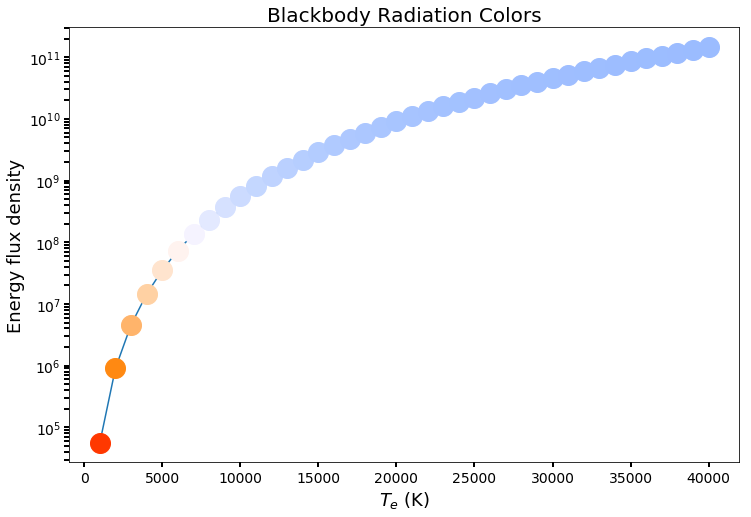

In [12]:
import csv
reader = csv.reader(open('../files/rgb_temp.csv', 'r'))
temps = []
rgbs = []
for row in reader:
   T, rgb = row
   temps.append(int(T))
   rgbs.append(rgb)

# calculate energy flux density for plotting
efds = [M_sb(T).value for T in temps]

# graph flux density vs temp
fig2 = plt.figure(figsize=(12,8))
plt.plot(temps[::10], efds[::10])
plt.xlabel('$T_e$ (K)', fontsize=18)
# plt.xscale('log')
plt.ylabel('Energy flux density', fontsize=18)
plt.yscale('log')
plt.tick_params(labelsize=14, which='both', length=5, width=2)
plt.title('Blackbody Radiation Colors', fontsize=20);

# add a few markers
x = temps[::10]
y = efds[::10]
ct = rgbs[::10]
for i in range(len(x)):
    plt.plot(x[i], y[i], 'o', color=ct[i], markersize=20)